2. Реализовать формулу релевантности

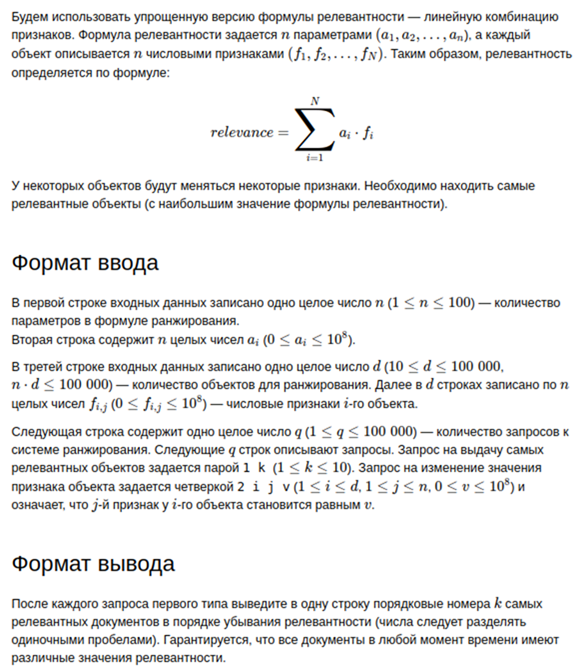

=====================================================

In [2]:
from rbtree import RedBlackTree

class RelevanceTree(RedBlackTree):
    def get_top_k(self, k):
        """
        Возвращает список ID топ-k объектов с наибольшей релевантностью.
        """
        result = []
            # Временная сложность O(k + log d):
            # log d тратим на спуск к самому правому (максимальному) элементу.
            # k тратим на сбор элементов (O(1) на переход к следующему).
        self._collect_top_k(self.root, k, result)
        return result

    def _collect_top_k(self, node, k, result):
        """
        Рекурсивный помощник.
        """
        # Базовый случай
        if node == self.NIL or len(result) >= k:
            return

        # 1. Идем вправо (к большим)
        self._collect_top_k(node.right, k, result)

        # 2. Берем текущий, если нужно
        if len(result) < k:
            rel, obj_id = node.data
            result.append(obj_id)
        else:
            return 

        # 3. Идем влево (к меньшим)
        self._collect_top_k(node.left, k, result)


def solve(request="input.txt"):
    with open(request, "r") as file:
        input_data = file.read().split()

    iterator = iter(input_data)

    n = int(next(iterator)) # Число признаков
    # [O] Парсинг вектора a: O(n)
    a = [int(next(iterator)) for i in range(n)]

    d = int(next(iterator)) # Число документов
    # [O] Парсинг матрицы признаков: O(d * n)
    features = [[int(next(iterator)) for i in range(n)] for j in range(d)]

    # 1.1 Инициализация Кр-Чёр древа
    # Будем хранить пары (relevance, id - для уникальности)
    tree = RelevanceTree()

    # 1.2 Вспомогательный массив для быстрого доступа к релевантности по ID
    current_relevance = [0] * d # [O] Память O(d)

    # 2. Заполнение древа
    # [O] Этот цикл суммарно занимает O(d * n + d * log d)
    for i in range(d):
        rel = 0
        # [O] Расчет релевантности: O(n)
        for j in range(n):
            rel += features[i][j] * a[j]
        current_relevance[i] = rel
        # [O] Вставка в RBT: O(log d)
        tree.insert((rel, i + 1))

    # 3. Обработка запросов
    output = []
    q = int(next(iterator))

    # [O] Общая сложность цикла запросов: 
    # O(q * log d) для обновлений и 
    # O(q * (k + log d)) для выборок.
    for _ in range(q):
        type_query = int(next(iterator))

        if type_query == 1:
            # Запрос топ k
            k = int(next(iterator))
            # [O] Время: O(k + log d)
            top_ids = tree.get_top_k(k)
            output.append(" ".join([str(elem) for elem in top_ids]))

        else:
            # Обновление
            obj_id = int(next(iterator))
            feature_idx = int(next(iterator))
            new_val = int(next(iterator))

            idx = obj_id - 1
            f_idx = feature_idx - 1

            # 1. Узнаем старую релевантность: O(1)
            old_rel = current_relevance[idx]

            # 2. Пересчитываем
            old_feature = features[idx][f_idx]
            features[idx][f_idx] = new_val

            # [O] O(1). 
            # НЕ пересчитываем сумму за O(n).
            new_rel = old_rel - (old_feature - new_val) * a[f_idx]

            # 3. Обновляем массив: O(1)
            current_relevance[idx] = new_rel

            # 4. Обновляем древо
            # [O] Удаление и вставка: O(log d)
            tree.delete((old_rel, obj_id))
            tree.insert((new_rel, obj_id))

    print("\n".join(output))

solve()

1 10
1 10 9 8 7 6 5 4 3 2
4 1 10 9 8 7 6 5 3 2


Теоретическая оценка алгоритма:

$d$ - количество объектов.

$n$ - количество признаков (размерность вектора $a$).

$q$ - количество запросов.

$k$ - параметр запроса топ-$k$.

$n \cdot d \le 10^5$, $k \le 10$, $q \le 10^5$

Примем, что типичная скорость вычисления в Python составляет $\sim 10^7$ оп/сек

* Время (Time Complexity):
  * Инициализация:
    * Чтение и создание матрицы features: $O(d \cdot n)$
    * Первичный расчет весов и построение дерева: $O(d \cdot n + d \log d)$
    * Итого init: $O(d \cdot n + d \log d)$
  * В контексте ограничений: Условие $n \cdot d \le 100'000$ гарантирует, что мы обрабатываем не более $10^5$ элементов.
  * Оценка времени: $\approx 0.05$ сек.

  * Запросы:
    * Type 1 (Top-k):
      * Алгоритм спускается по дереву и собирает $k$ узлов. Сложность: $O(k + \log d)$
      * $k \le 10$ + $(\log d \le \log_2(10^5) \approx 17)$. Суммарно $\le 30$ операций на запрос

    * Type 2 (Update):
      * Пересчет значения: $O(1)$
      * Удаление старого узла: $O(\log d)$
      * Вставка нового узла: $O(\log d)$
      * Итого update: $O(1 + 2 \log d) \approx O(\log d)$. При $D_{max} = 100,000$, высота дерева $h \approx \log_2(10^5) \approx 17$. Выходит, что производится $\approx 35$ элементарных операций на запрос.

  * При $q=10^5$ это суммарно $\approx 5 \cdot 10^6$ операций.  
  * **Оценка времени:** $\approx 0.3 - 0.6$ сек.
  * Общая асимптотика программы:
    $$O\Big( d \cdot n + d \log d +  q \cdot (k + \log d) \Big)$$
  

* Память (Space Complexity):
  * Данные:
    * Матрица features: $O(d \cdot n)$.
    * Дерево: $O(d)$.
    * Массив релевантности и вектор $a$: $O(d) + O(n)$.
  * Итого: $O(d \cdot n )$.
